<a href="https://colab.research.google.com/github/naorJR/IP-Labs/blob/ortra/Lab%205/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5 - Image Restoration

## Goal: Introduction to image restoration

## ---  Make sure you are using GPU accelerator in Colab Runtime  ---

Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd '/content/drive/My Drive/IP Labs/5/'
%ls
import os
path = os.getcwd() 
print('path: ' + path)

Mounted at /content/drive/
/content/drive/My Drive/IP Labs/5
 BoatsColor.jpg   ex5_pre_code.ipynb   Lab5.ipynb  'Lab 5 Manual.pdf'   net.pth
path: /content/drive/My Drive/IP Labs/5


Import the necessary libraries

In [2]:
%matplotlib inline 
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
from skimage import transform,io,util,img_as_float, img_as_ubyte
from skimage.color import rgb2gray
from skimage import restoration
import cv2
import random
from scipy import signal,ndimage

In [3]:
class Images():
    def __init__(self, image, title):
        self.image = image
        self.title = title

def plotImages(images,dim, size=(20, 15)):                                               
  fig, ax = plt.subplots(dim[0],dim[1],figsize=size)
  ax = ax.ravel()
  for i,image in enumerate(images):
    ax[i].imshow(image.image, cmap='gray',vmin = 0,vmax = 255)
    ax[i].set_title(image.title)
    ax[i].set_xlabel('Width [px]')
    ax[i].set_ylabel('Height [px]')
  plt.tight_layout()

  plt.show()



###  Part 1 - Median Filter

1. Insert your implementaion from the preliminary report to add salt and pepper noise to an image:

In [4]:
# Insert your answer here
def sp_noise(image,p):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    p = p/2
    noisy = image.copy()
    rnd = np.random.rand(image.shape[0], image.shape[1])
    noisy[rnd < p] = 0
    noisy[rnd > 1 - p] = 255
    return noisy


**2**. Load a grayscale uint8 image

Image shape:(576, 787), Image data type:uint8


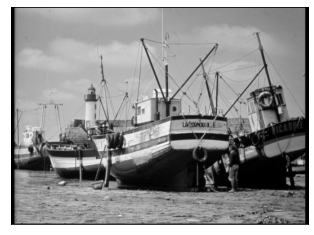

In [5]:
# Insert your answer here
img = rgb2gray(io.imread('BoatsColor.jpg'))
img = img_as_ubyte(img)
print ('Image shape:{}, Image data type:{}'.format(img.shape,img.dtype))
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X & Y axis
plt.show()

3. Add to image salt and pepper noise with different p values - 1%, 5%, 10%.
  Show the outputs. Print a small patch from every image such that the noise can be seen clearly (total 6 images).

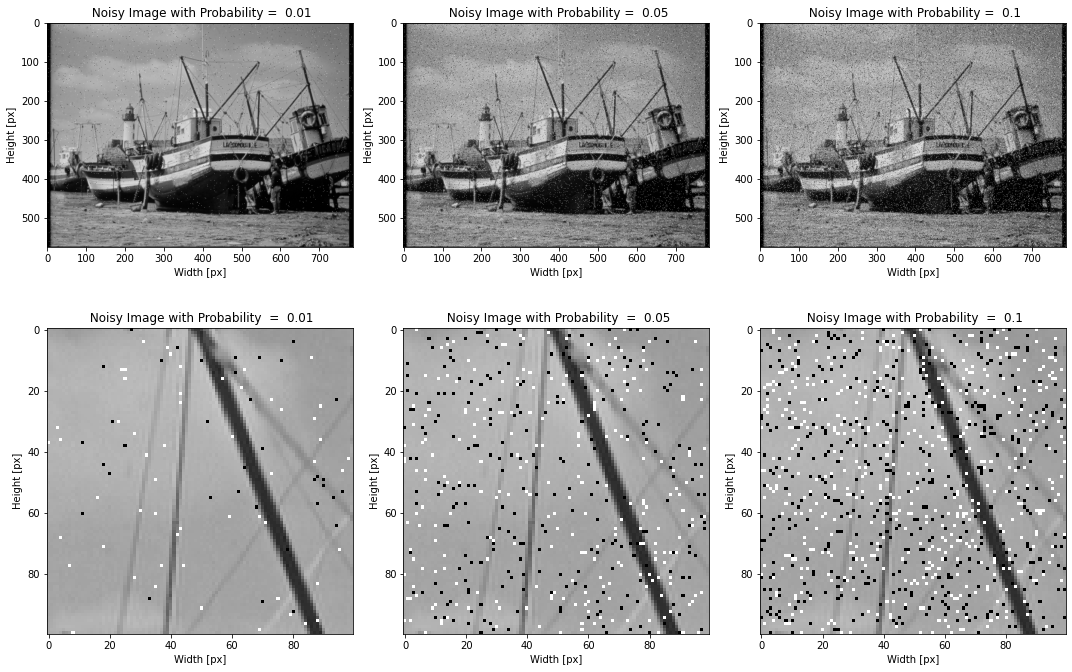

In [6]:
# Insert your answer here
noisy_img = []
P = [0.01,0.05,0.1]
for p in P :
  noisy_img.append(Images(sp_noise(img,p)," Noisy Image with Probability =  " + str(p)  ))
for p in P :
  noisy_img.append(Images(sp_noise(img,p)[100:200,300:400]," Noisy Image with Probability  =  " + str(p)  ))

plotImages(noisy_img, [2,3], (15, 10))

4. Apply a median filter on the 3 noisy images to reduce the noise. You may choose different values for the kernel_size parameter. Print the results. Print 3 pairs of patches with same indexing, where the first patch is from the noisy image and the second is from from filtered image. Did the filter work? Explain the edge conservation property of the median filter in relation to your results.

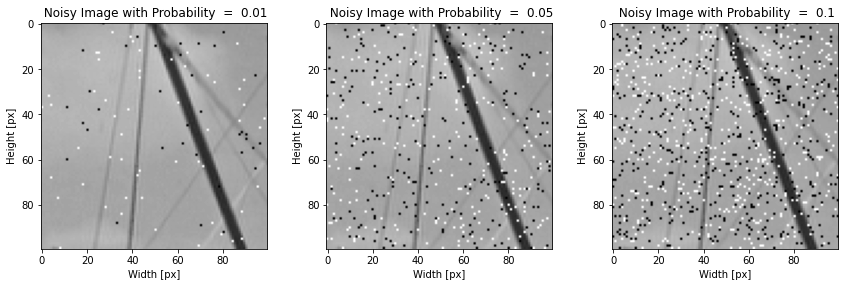

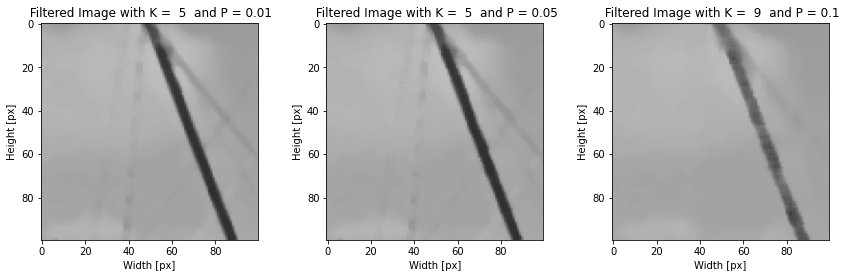

In [7]:
# Insert your answer here
filtered_img = [] # append the noisy img
K = [5,5,9]
for i in range(0,3) :
  filtered_img.append(Images(cv2.medianBlur(noisy_img[i].image,K[i])[100:200,300:400]," Filtered Image with K =  " + str(K[i]) + "  and P = " + str(P[i]) ))

plotImages(noisy_img[3:6], [1,3], (12, 12))
plotImages(filtered_img, [1,3], (12, 12))

Like the mean filter, the median filter considers each pixel in the image in turn and looks at its nearby neighbors to decide whether or not it is representative of its surroundings.  it replaces it with the median of those values. In general, the median filter allows a great deal of  removing noise on images where less than half of the pixels in a smoothing neighborhood have been effected. lets demonstarate a 3x3 kernel - first  
we sort all the  9 pixels, then in the case of  paper noise (pixel that changed to 0) the  median filter  fail if  the fifth pixel  equal 0 ,but the fifth pixel will be  0 if  at least 5 out of 9 pixels are also 0 (becasue  the 9 pixels are sorted ) thats mean that the probability to fail its (p/2)^5 . 
ofcourse same apply for the salt noise ( 255 instead of 0 ).
In addition,Since the median value must actually be the value of one of the pixels in the neighborhood, the median filter does not create new unrealistic pixel values when the filter straddles an edge. For this reason the median filter is much better at preserving sharp edges than the mean filter. we can see in our result that the the median filter preserving sharp edges. When the noise density is increased  in order to completely remove the noise. we will need to increase the kernel size in that case  serious blurring occurs at the edges.

###  Part 2 - Inverse Filter

1. Insert your implementaion from preliminary report - add blurring and Gaussian noise to image:

In [8]:
# The function return two images: a blurred image 
# and an image after blurring and noise adding
def AddBlurreAndNoise_TIME(img, filter_blur,v=0.01):
    # Insert your implementaion here
    img_blurre = cv2.filter2D(img, -1, filter_blur,borderType = 0)
    img_blurre_noise = random_noise(img_blurre, mode='gaussian', var=v)
    return img_blurre, img_blurre_noise
    

In [9]:
def my_fft_filter2d(img,kernel,mode = 'valid'):
  sz  = tuple([img.shape[0]+kernel.shape[0]-1,img.shape[1]+kernel.shape[1]-1])
  H = np.fft.fft2(kernel, s = sz)
  F = np.fft.fft2(img, s = sz)
  G = F * H
  g = np.abs(np.fft.ifft2(G)) 
  if mode == 'valid':
    img_filtered = g[kernel.shape[0]-1:img.shape[0],kernel.shape[1]-1:img.shape[1]]
  if mode == 'same':
    if kernel.shape[0]%2 == 0 :
        s1,s2 = int(kernel.shape[0]/2)-1,int(kernel.shape[1]/2)-1 # kernel shape is even in example 6x6
    if kernel.shape[0]%2 != 0 :
        s1,s2 = int(kernel.shape[0]/2),int(kernel.shape[1]/2) #  kernel shape is odd in example 5x5
    img_filtered = g[s1:(img.shape[0]+s1),s2:(img.shape[1]+s2)]
  if mode == 'full':
    img_filtered = g[0:(img.shape[0]+kernel.shape[0]-1), 0:(img.shape[1]+kernel.shape[1]-1)] 
  
  return img_filtered

for better understanding we will implement also blurring and noise in the frequency domain because in this exercise all the filters are in the frequency domain

In [10]:
def AddBlurreAndNoise_FREQUENCY(img, filter_blur,v=0.01):
    # Insert your implementaion here
    img_blurre = my_fft_filter2d(img,filter_blur,'same')
    img_blurre_noise = random_noise(img_blurre, mode='gaussian', var=v)
    return img_blurre, img_blurre_noise


2. Load image as float64:

Image shape:(576, 787), Image data type:float64


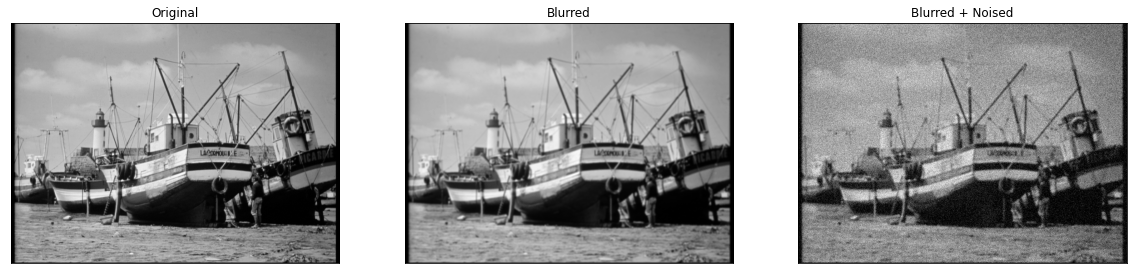

In [11]:
img = io.imread('BoatsColor.jpg', as_gray = True)
img = img_as_float(img)  #keep this line!
print ("Image shape:{}, Image data type:{}".format(img.shape,img.dtype))
# Use gaussian kernel for burring the image
# gaussian kernel is separable function
filter_blur = cv2.getGaussianKernel(ksize=5,sigma=1.85)*cv2.getGaussianKernel(ksize=5,sigma=1.85).T 

blurred, noise = AddBlurreAndNoise_TIME(img,filter_blur)
blurred_F, noise_F = AddBlurreAndNoise_FREQUENCY(img,filter_blur)
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(blurred, cmap='gray'),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised')
plt.xticks([]), plt.yticks([])
plt.show()

In [12]:
def calc_RMS(f, f_hat):
  # Insert your code:
  RMS = np.sqrt(np.mean((f-f_hat)**2))
  return RMS

print("rms error between blurred to blurred_fft {}".format(calc_RMS(blurred,blurred_F)))
print("rms error between noise to noise_fft {}".format(calc_RMS(noise,noise_F)))

rms error between blurred to blurred_fft 1.8699135262791524e-16
rms error between noise to noise_fft 0.1359234879160902


we can see that both the time domain filter and the frequency domain gave the same result : rms between the blurred images are e^-16

3. Test the restoration with the Inverse Filter for deblurring and denoising

In [13]:
def InverseFilter(img,kernel,mode = 'valid'): #same as regular filter in frequency domain only need to add H_I = 1/H
  sz  = tuple([img.shape[0]+kernel.shape[0]-1,img.shape[1]+kernel.shape[1]-1])
  H = np.fft.fft2(kernel, s = sz)
  F = np.fft.fft2(img, s = sz)
  H_I = 1/H
  G = F*H_I
  g = np.abs(np.fft.ifft2(G)) 
  if mode == 'valid':
    img_filtered = g[kernel.shape[0]-1:img.shape[0],kernel.shape[1]-1:img.shape[1]]
  if mode == 'same':
    if kernel.shape[0]%2 == 0 :
        s1,s2 = int(kernel.shape[0]/2)-1,int(kernel.shape[1]/2)-1 # kernel shape is even in example 6x6
    if kernel.shape[0]%2 != 0 :
        s1,s2 = int(kernel.shape[0]/2),int(kernel.shape[1]/2) #  kernel shape is odd in example 5x5
    img_filtered = g[s1:(img.shape[0]+s1),s2:(img.shape[1]+s2)]
  if mode == 'full':
    img_filtered = g[0:(img.shape[0]+kernel.shape[0]-1), 0:(img.shape[1]+kernel.shape[1]-1)] 
  
  return img_filtered

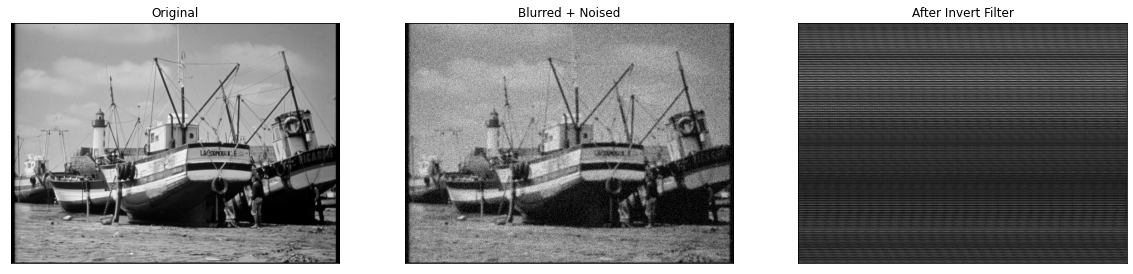

In [14]:
denoise_Invert_img = InverseFilter(noise,filter_blur,'same')
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_Invert_img, cmap='gray'),plt.title('After Invert Filter')
plt.xticks([]), plt.yticks([])
plt.show()

4. What is the problem with the Inverse Filter? How can this be solved?

Insert your answer here
#### Answer 2
---
Let us call the fft of the kernel H and the fft of the original and noise  imgaes F and G respectively .
We know that the noised image in the frequency domain G = FH + N (N is the fft of the noise) in the time domain g = f * h + n (* is convolution)
H may have values that equal to zero (or close to zero), s.t. when we are using the inverse filter we are dividing the  noise image's fft by H and we get :
G/H = (FH + N) / H = F+N/H . In the values that close to zero the noise will explode to very large values . We can solve this problem by setting some treshold condition s.t every value under this TH in the H matrix will remain zero after the dividing operation. This solution called pseudo inverse.

---

### Part 3 - Pseudo Inverse Filter

1. Test the restoration with the Pseudo Inverse Filter for deblurring and denoising.

In [15]:
def PseudoInverseFilter(img, kernel, epsilon=0.5,mode = 'valid'):
  sz  = tuple([img.shape[0]+kernel.shape[0]-1,img.shape[1]+kernel.shape[1]-1])
  H = np.fft.fft2(kernel, s = sz)
  F = np.fft.fft2(img, s = sz)
  H_I = 1/H
  H_I[H<epsilon] = 0
  G = F*H_I
  g = np.abs(np.fft.ifft2(G)) 
  if mode == 'valid':
    img_filtered = g[kernel.shape[0]-1:img.shape[0],kernel.shape[1]-1:img.shape[1]]
  if mode == 'same':
    if kernel.shape[0]%2 == 0 :
        s1,s2 = int(kernel.shape[0]/2)-1,int(kernel.shape[1]/2)-1 # kernel shape is even in example 6x6
    if kernel.shape[0]%2 != 0 :
        s1,s2 = int(kernel.shape[0]/2),int(kernel.shape[1]/2) #  kernel shape is odd in example 5x5
    img_filtered = g[s1:(img.shape[0]+s1),s2:(img.shape[1]+s2)]
  if mode == 'full':
    img_filtered = g[0:(img.shape[0]+kernel.shape[0]-1), 0:(img.shape[1]+kernel.shape[1]-1)] 
  
  return img_filtered

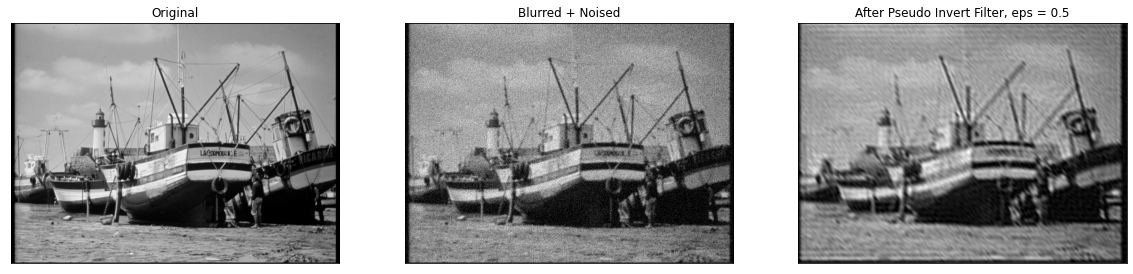

In [16]:
epsilon = 0.5
denoise_pseudo_img = PseudoInverseFilter(noise,filter_blur,epsilon,'same')
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_pseudo_img, cmap='gray'),plt.title('After Pseudo Invert Filter, eps = {}'.format(epsilon))
plt.xticks([]), plt.yticks([])
plt.show()

The Root Mean Square (RMS) error of restoration is defined in the following way:
\begin{equation*}
RMS = \left( \frac{1}{MN}  \sum_{k=0}^{M-1} \sum_{k=0}^{N-1} (\hat{f}(i,j)-f(i,j))^2 \right)^{0.5}
\end{equation*}

where $f(i, j)$ is the original image, $\hat{f}(i,j)$ is the restored image and $M \times N$ is the size of both images. 


In [17]:
def calc_RMS(f, f_hat):
  # Insert your code:
  RMS = np.sqrt(np.mean((f-f_hat)**2))
  return RMS

2. Plot the graph of the RMS error (Y axis) versus the parameter $\epsilon$(X axis) . Use several values in the range 0-1

(the variance of the noise $\sigma _n ^2$ is fixed to the default value in the supplied program).


In [18]:
# Insert your code here
blurred, noise = AddBlurreAndNoise_TIME(img,filter_blur)
epsilons = np.arange(0.1, 1.1, 0.01).tolist()
rms = []
for e in epsilons :
  denoise_pseudo_img = PseudoInverseFilter(noise,filter_blur,e,'same')
  rms.append(calc_RMS(img,denoise_pseudo_img))


Text(0, 0.5, 'RMS')

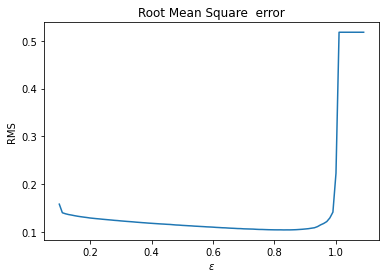

In [19]:
plt.plot(epsilons,rms)
plt.title('Root Mean Square  error')
plt.xlabel(r'$\epsilon$')
plt.ylabel('RMS')

__Show the result of the best restoration by the best epsilon value.__ (if it different than the previous shown result)


#### Note
---
This is the same epsilon value, so we don't show the image again. 

---

3.Now fix the parameter $\epsilon = 0.5$.
Plot the graph of the Root Mean Square (RMS) error of restoration (Y axis) versus the
variance of the noise $\sigma_n^2$ (X axis).
__And Show the result of the best restoration__
(Use several values in the range 0-1)

In [20]:
# Insert your code here
VARS = np.arange(0, 1, 0.01).tolist()
rms = []
for v in VARS :
  blurred,noise = AddBlurreAndNoise_TIME(img,filter_blur,v)
  denoise_pseudo_img = PseudoInverseFilter(noise,filter_blur,mode ='same')
  rms.append(calc_RMS(img,denoise_pseudo_img))

Text(0, 0.5, 'RMS')

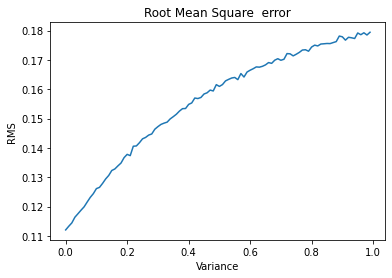

In [21]:
# Insert your code here
plt.plot(VARS,rms)
plt.title('Root Mean Square  error')
plt.xlabel('Variance')
plt.ylabel('RMS')

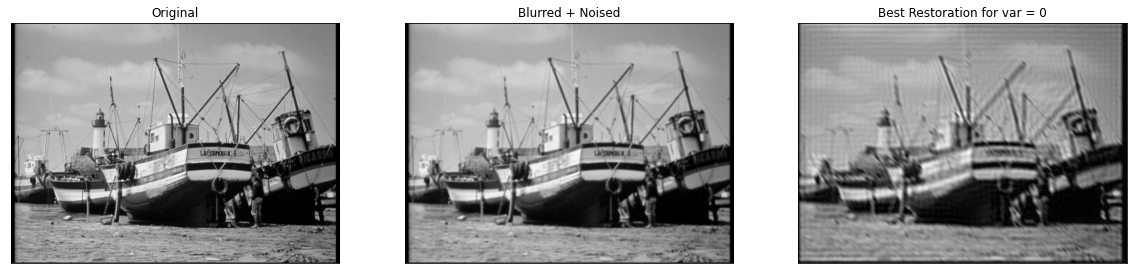

In [22]:
var=0
blurred , noise = AddBlurreAndNoise_TIME(img,filter_blur,var)
denoise_pseudo_img = PseudoInverseFilter(noise,filter_blur)
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_pseudo_img, cmap='gray'),plt.title('Best Restoration for var = {}'.format(var))
plt.xticks([]), plt.yticks([])
plt.show()

   3.1. For what maximal value of the variance of the noise you still get an acceptable restoration? **show the noisy and result plots**

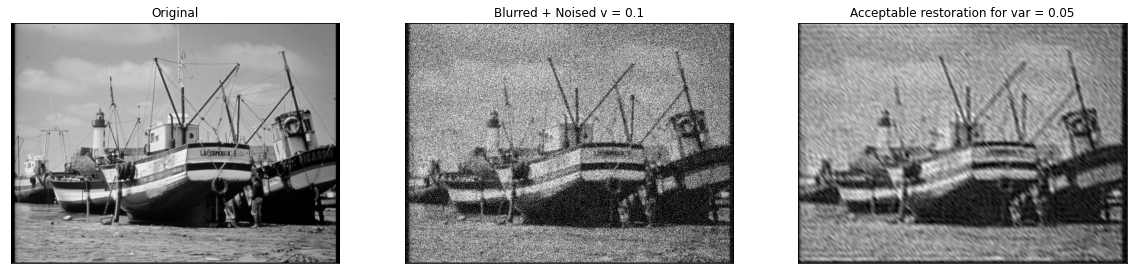

In [23]:
var = 0.05
blurred , noise = AddBlurreAndNoise_TIME(img,filter_blur,var)
denoise_pseudo_img = PseudoInverseFilter(noise,filter_blur)
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurred + Noised v = 0.1')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_pseudo_img, cmap='gray'),plt.title('Acceptable restoration for var = {}'.format(var))
plt.xticks([]), plt.yticks([])
plt.show()

#### Answer 3
---
The maximal value of the variance of the noise we still get an acceptable restoration is 0.05.

---

### Part 4 - Wiener Filter

1. Test the restoration with the Wiener Filter for deblurring and denoising

Assume that the variance used in the Wiener filter formula is equal to the variance of the noise $\sigma_n^2$
, and both of them are equal to 0.01 (for image in a range of 0-1) or 0.01 ∗ 255
(for image in a range of 0-255).

In [24]:
sigma_noise=0.01
blurred , noise = AddBlurreAndNoise_TIME(img,filter_blur,sigma_noise)

In [92]:
def WienerFilter(noise_img, kernel, sigma=0.01, alpha=0.095):
    sz = tuple([noise_img.shape[0]+kernel.shape[0]-1,noise_img.shape[1]+kernel.shape[1]-1])
    H = np.fft.fft2(kernel, s = sz)
    G = np.fft.fft2(noise_img, s = sz)
    K = np.conj(H) / (np.abs(H)**2 + sigma / alpha)
    F = G * K
    f_hat = np.real(np.fft.ifft2(F))
    return f_hat[:noise_img.shape[0], :noise_img.shape[1]]

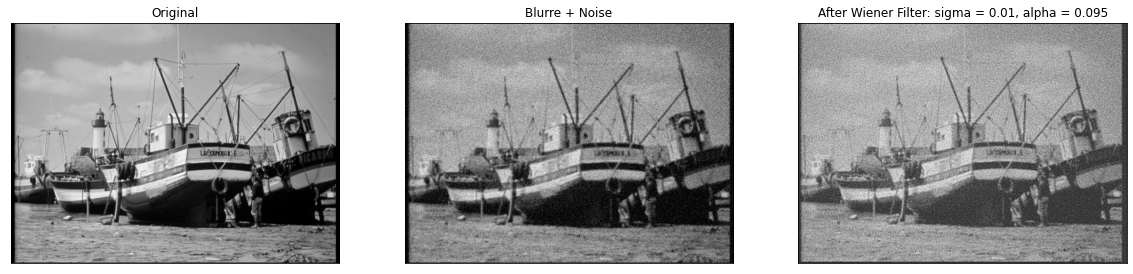

In [93]:
sigma = sigma_noise
alpha = 0.095
denoise_wiener_img = WienerFilter(noise,filter_blur,sigma, alpha)
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurre + Noise')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_wiener_img, cmap='gray'),plt.title('After Wiener Filter: sigma = {}, alpha = {}'.format(sigma, alpha))
plt.xticks([]), plt.yticks([])
plt.show()

2. Plot the graph of the Root Mean Square (RMS) error of restoration (Y axis) versus the parameter $\sigma_n^2$ (X axis) (change $\sigma_n$ only in the filter, the noise image stay the same, also no need to change alpha). __Show the result of the best restoration.__

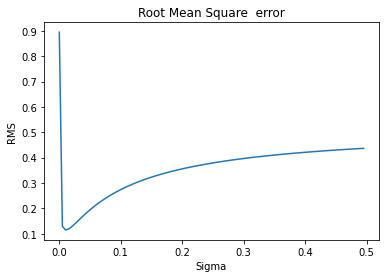

In [94]:
# Insert your code here
sigmas = np.arange(0.0001, 0.5, 0.005).tolist()
a = 0.095
rms = []
for s in sigmas:
  denoise_wiener_img = WienerFilter(noise,filter_blur,s, a)
  rms.append(calc_RMS(img,denoise_wiener_img))
plt.plot(sigmas,rms)
plt.title('Root Mean Square  error')
plt.xlabel('Sigma')
plt.ylabel('RMS')
plt.show()

#### Note 2
---
We can see that the error graph behaves like a function f=1/x, as expected from the Winer filter form.
Such that the optimal value we be given at variance = sigma = 0.01 as expected. Exactly where the variance of the noice.

---

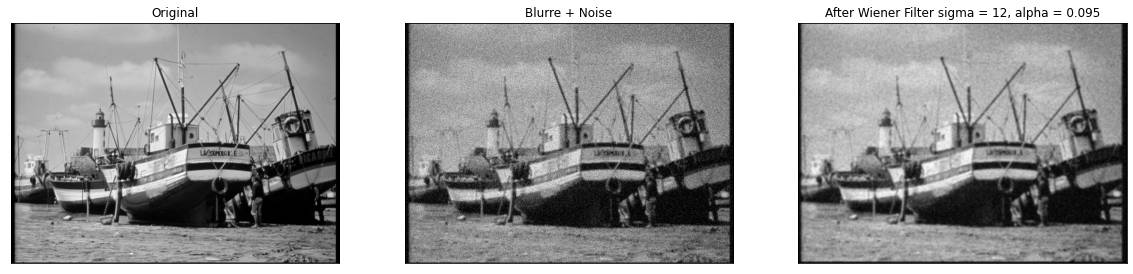

In [95]:
sigma = 12
alpha = 0.095
denoise_wiener_img = WienerFilter(noise,filter_blur,sigma)
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurre + Noise')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_wiener_img, cmap='gray'),plt.title('After Wiener Filter sigma = {}, alpha = {}'.format(sigma, alpha))
plt.xticks([]), plt.yticks([])
plt.show()

### Part 5 - Deep learning (DnCNN)

1. After using a few filters to restoration the image, Lets try with the new **Deep learning** approach and compare the results

For building the neural network we will use the [PyTorch framwork](https://pytorch.org/) 

Because of a lack of time we aren't going to train the network here.
We will use a pretrained model

First, a few more imports for using pytorch:

In [29]:
# run this
!pip3 install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import torch
import torch.nn as nn
from torch.autograd import Variable

Now we will define the architecture of the neural network.

We will implement the [DnCNN](http://www4.comp.polyu.edu.hk/~cslzhang/paper/DnCNN.pdf) architecture:

Here you can see the architecture is a class that inherits from nn.Module (pytorch module) 

In [31]:
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        # first layer: conv2d -> Relu (for activation) :
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        # then lets defined all the other hidden layer as: conv2d -> BatchNorm -> Relu
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        # and at the end: need to get back the image so conv2d with out_channels as in the original image:
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        # insert all the layers in to Sequential that will pass the data in order
        self.dncnn = nn.Sequential(*layers)
        
    def forward(self, x):
        # defined the forward pass of our network
        out = self.dncnn(x)
        return out


Note that we do not need to define the back propagation, as the Pytorch framework does that for us.

2. What is the *Conv* in the network architecture? Give a brief explanation (up to 4 lines)

#### Answer 4
---
**Spesific Answer:**
The Conv in the code above is a 2D convolutional layer that applies a convolution operation over the input data using a set of 2D kernels.

**General Answer:** 
The convolutional layers use a set of learnable kernels (or filters) to extract features from input data by sliding the kernels over the input and performing element-wise multiplications and summations. 
The output of a convolutional layer is called a feature map and has a reduced spatial dimension compared to the input, since each output element is the result of a convolution of a local neighborhood in the input.

---

After building the network architecture, we need to load the pretrained model and feed it the noisy image:

In [32]:
def DnCNN_network(noise_img, num_of_layers=17, model_path='net.pth'):
    
    print('Loading model ...')
    # defined the network, use the class we create above
    net = DnCNN(channels=1, num_of_layers=num_of_layers)
    traind_model = nn.DataParallel(net)
    # load pretrain model
    pretraind = torch.load(model_path)
    # get the state of the model (weights + baises ...)
    traind_model.load_state_dict(pretraind)
    traind_model.double()
    # say to pytorch that we juist want to test the model (not tarin it)
    traind_model.eval()
    print('Loaded\n')
    # Expend dim for using the network:
    noise_img = np.expand_dims(noise_img, 0) # batch dim
    noise_img = np.expand_dims(noise_img, 1) # channels dim
    # cast to tensor variable 
    noise_img = torch.DoubleTensor(noise_img)
    INoisy = Variable(noise_img)
    
    with torch.no_grad(): # this can save much memory
        print("Inserting the noisy image...\n")
        the_noise_that_we_learned = traind_model(INoisy)
        plt.imshow(the_noise_that_we_learned.cpu().squeeze(), cmap='gray'),plt.title('The noise that the network predict')
        plt.show()
        Out = torch.clamp(INoisy.cpu() - the_noise_that_we_learned.cpu(), 0., 1.)
    return Out.squeeze()



3. Explain the following line in the code. Why do we need this line? 

*Out = torch.clamp(INoisy.cpu() - the_noise_that_we_learned.cpu(), 0., 1.)*


#### Answer 5
---
The model is predicting the noise therefore,This line is subtracting the noise prediction made by the trained model from the input noisy image, element-wise. The clamp function is then applied to the result to ensure that all elements are between 0 and 1 (the range of valid pixel values for a grayscale image). This is done to ensure that the output image is a valid image with pixel values in the expected range.

The clamp function limits the minimum and maximum values that an element in the input tensor can take. In this case, it is ensuring that the output image has pixel values between 0 and 1 by setting all values below 0 to 0 and all values above 1 to 1.

---

Now let's use the neural network and show the results:

Loading model ...
Loaded

Inserting the noisy image...



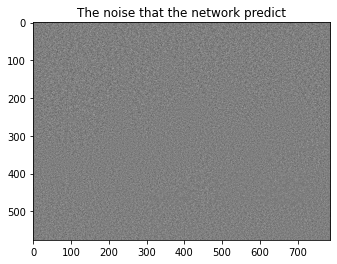

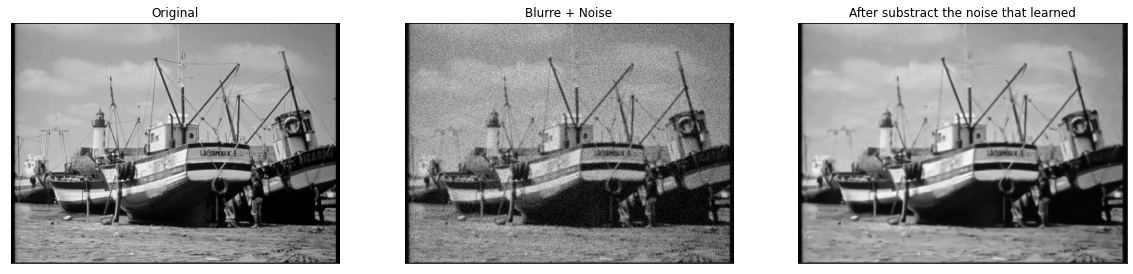

In [33]:
denoise_dncnn_img = DnCNN_network(noise)

plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(noise, cmap='gray'),plt.title('Blurre + Noise')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_dncnn_img, cmap='gray'),plt.title('After substract the noise that learned')
plt.xticks([]), plt.yticks([])
plt.show()

### Part 6 - Comparison

1. Lets compare the results from all the methods that we used in this lab:

Show the best image after restoration from all the methods (Pseudo Invers Filter, Wiener Filter, DnCNN). which one do you think is better?

Loading model ...
Loaded

Inserting the noisy image...



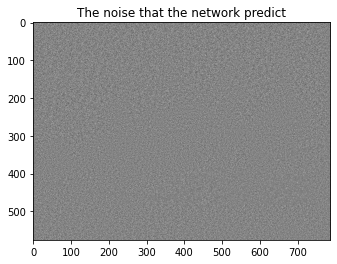

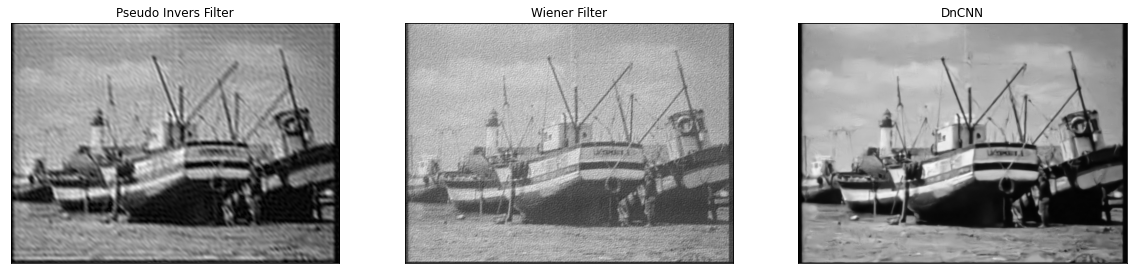

In [34]:
# Insert your code here
blurred , noise = AddBlurreAndNoise_TIME(img,filter_blur,0.01)
denoise_pseudo_img = PseudoInverseFilter(noise,filter_blur,mode = 'same')
denoise_wiener_img = WienerFilter(noise,filter_blur,15)
denoise_dncnn_img = DnCNN_network(noise)
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(denoise_pseudo_img, cmap='gray'),plt.title('Pseudo Invers Filter')
plt.xticks([]), plt.yticks([]) 
plt.subplot(132),plt.imshow(denoise_wiener_img, cmap='gray'),plt.title('Wiener Filter')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(denoise_dncnn_img, cmap='gray'),plt.title('DnCNN')
plt.xticks([]), plt.yticks([])
plt.show()

#### Answer 6
---
It easy clearly to see that the DnCNN give much better results :)

---

Now we will use a quantitive metric to examine the reconstruction. We will use Structural similarity index (ssim). You may read about it online. ssim 1 means exact reconstruction, ssim 0 means worst reconstruction.

In [35]:
from skimage.metrics import structural_similarity as ssim

def calc_ssim(original_image, reconstract_image):
  original_image = img_as_float(original_image)
  reconstract_image = img_as_float(reconstract_image)
  ssim_metric = ssim(original_image, reconstract_image,
                  data_range=original_image.max() - original_image.min())
  return ssim_metric

2. Make a quantitive comparison of the reconstruction of all metheds (Pseudo Invers Filter, Wiener Filter, DnCNN). You may use the provided method. Print the ssim metric for each reconstruction method. Which one is the best?

In [36]:
# Insert your answer here
print("The ssim metric is:\n Pseudo Inverse Filter,: {}\n Wiener Filter: {}\n DnCNN: {}".format(calc_ssim(img,denoise_pseudo_img)
,calc_ssim(img,denoise_wiener_img), calc_ssim(img,denoise_dncnn_img)))

The ssim metric is:
 Pseudo Inverse Filter,: 0.4203926130762024
 Wiener Filter: 0.2694596830516761
 DnCNN: 0.7512529844382666


#### Answer 7
The best restoration according to the SSIM metric:
1. DnCNN
2. Pseudo Inverse Filter
3. Wiener Filter

The best result of the DnCNN is expected according to the comparison above, but the fact that the Pseudo Inverse filter is better then the Wiener was not expected since the image of the winner filter seen more acceptable than the Pseudo Inverse one.